In [11]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms


import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import PIL

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- [ ]  auto contrast
- [ ] brightness
- [ ] to grayscale with prob p
- [ ] constrast change
- [ ] equalize
- [ ] invert 
- [ ] do nothing
- [ ] rescale
- [ ] posterize
- [ ] solarize
- [ ] rotate + rescale
- [ ] sharpness
- [ ] smooth
- [ ] flipx
- [ ] flipy

In [7]:
np.random.choice(np.arange(1, 8))

4

In [205]:
def cutout_test(image, p):

    image = np.asarray(image).copy()

    draw = np.random.rand()
    if draw > p:
        return image

    h, w = image.shape[:2]

    draw = np.random.uniform(0, 0.5, 1)
    if draw == 0:
        return image
    else:
        patch_size = int(draw * h)

    lu_x = np.random.randint(0, w - patch_size)
    lu_y = np.random.randint(0, h - patch_size)

    mask_color = np.asarray([0.5, 0.5, 0.5])

    image[lu_y:lu_y + patch_size, lu_x:lu_x + patch_size] = mask_color

    return image


def auto_contrast(image):
    return PIL.ImageOps.autocontrast(image)

    
def brightness(image):
    enhancer = PIL.ImageEnhance.Brightness(image)
    factor = np.random.random()
    enhancer.enhance(factor)
    return image
    

def contrast(image):
    enhancer = PIL.ImageEnhance.Contrast(image)
    factor = np.random.random()
    enhancer.enhance(factor)
    return image
    
    
def equalize(image, alpha=0.3):    
    eq_image = PIL.ImageOps.equalize(image)
    blend_image = PIL.Image.blend(image, eq_image, alpha)
    return blend_image
            

def invert(image, alpha=0.3):
    inv_image = PIL.ImageOps.invert(image)
    blend_image = PIL.Image.blend(image, inv_image, alpha)
    return blend_image


def nop(image):
    return image


def posterize(image):
    num_bits = np.random.choice(np.arange(1, 8))
    return PIL.ImageOps.posterize(image, num_bits)


def solarize(image):
    max_val = image.getextrema()[0][0]
    values = np.linspace(0, max_val, 256)
    threshold = np.random.choice(values)
    return PIL.ImageOps.solarize(image, threshold)


def sharpness(image):
    radius = 2
    percent = 150
    threshold = 3
    H = PIL.ImageFilter.UnsharpMask(radius, percent, threshold)
    image = image.filter(H)
    return image


def smooth(image):
    radius = 0.5
    H = PIL.ImageFilter.GaussianBlur(radius)
    image = image.filter(H)
    return image

In [206]:
# image = PIL.Image.open('test.jpg')
# inv_image = PIL.ImageOps.invert(image)
# blend_image = PIL.Image.blend(inv_image, image, 0.3)

In [207]:
# plt.imshow(blend_image)

In [208]:
transform_list = [
    transforms.Lambda(lambda x: auto_contrast(x)),
    transforms.Lambda(lambda x: brightness(x)),
    transforms.RandomGrayscale(p=0.2),
    transforms.Lambda(lambda x: contrast(x)),
    transforms.Lambda(lambda x: equalize(x, alpha=0.3)),
    transforms.Lambda(lambda x: invert(x, alpha=0.3)),
    transforms.Lambda(lambda x: nop(x)),
    transforms.RandomResizedCrop(32),
    transforms.Lambda(lambda x: posterize(x)),
    transforms.Lambda(lambda x: solarize(x)),
    transforms.RandomRotation(degrees=35),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Lambda(lambda x: sharpness(x)),
    transforms.Lambda(lambda x: smooth(x)),
    transforms.Lambda(lambda x: cutout_test(x, p=1.0))
]

transform_compose = transforms.Compose([
    transforms.RandomChoice(transform_list),
    transforms.ToTensor()
])

In [209]:
class LoaderCIFAR(object):
    def __init__(self, file_path, transform_compose, download, batch_size, use_cuda):

        kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

        # Get the datasets
        train_dataset = self.get_dataset(file_path, transform_compose, download)
        
        # Set the loaders
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)

    @staticmethod
    def get_dataset(file_path, transforms_compose, download):

        # Training and Validation datasets
        train_dataset = CIFAR10(root=file_path, train=True, download=download,
                                        transform=transforms_compose,
                                        target_transform=None)
        return train_dataset


In [210]:
loader = LoaderCIFAR('../data', transform_compose, True, 16, False)
train_loader = loader.train_loader
x = train_loader.__iter__().__next__()[0]

Files already downloaded and verified


In [211]:
im = x[0].numpy().transpose(1, 2, 0)

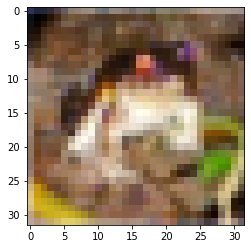

In [212]:
plt.imshow(im)